# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10' # camera pc ip
```

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = False
ENABLE_DETECT = False
ENABLE_O3D = True

CONNECT_INDY = False
CONNECT_MOBILE = False

VISUALIZE = False
PLANNING_MULTIPROC = True

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.08, 0.32]
# TOOL_OFFSET = 0.01
TOOL_OFFSET = 0.1 # tested one
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.21.12"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.21.12
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections

from utils.streaming import *
from utils.detection_util import *


from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=(1,1,1,0.2), display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 8, -7, 7, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, 
# face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=True, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "Z"), (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(RobotType.indy7, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)


add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, 
                       tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"

connection command:
kmb0: True
indy1: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7-frontZ-PRQ.pkl
Loaded: indy7-frontX-PRQ.pkl
Loaded: indy7-upZ-PRQ.pkl
Loaded: indy7-downZ-PRQ.pkl


In [3]:
# from pkg.ui.ui_broker import *

# # start UI
# ui_broker = UIBroker.instance()
# ui_broker.initialize(ppline, s_builder)
# ui_broker.start_server()

# ui_broker.set_tables()

#### 0.1.2 Load environment map

In [4]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 80 
kmb.validifier = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE))<VALID_SCORE_CUT)
kmm.init_node(timeout=10)

In [5]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [6]:
from utils.shared_detector import SharedDetector
sd = SharedDetector()
if ENABLE_DETECT:
    sd.init()

#### 1.1.1 Move to bed-seek pose 

In [7]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

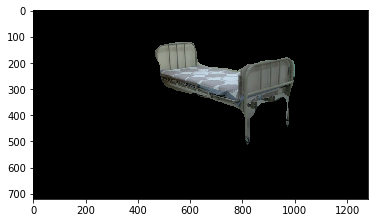

In [8]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
        rdict = stream_capture_image(
            ImageType.FirstView, obj_type="bed", host=CAM_HOST,
            crob=crob)
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected table)
        mask_out = sd.inference(color_img=rdict['color'])
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))[:,:,0]
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [9]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [10]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)
if ENABLE_O3D:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed.STL', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))
        
        with gtimer.block("ICP"):
            Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
            Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)
    
    bed_center = T_bo_bed[:3,3]
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    if Rot_rpy(bed_rpy)[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))

bed_vis = gscene.NAME_DICT["bed_vis"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.903842e-01, inlier_rmse=6.829974e-02, and correspondence_set size of 31029
Access transformation to get result.
Transformation is:
[[ 0.79290994 -0.0555432   0.60680209 -0.79034828]
 [-0.27436259 -0.92172223  0.27414117 -0.0935863 ]
 [ 0.54407628 -0.38385306 -0.74608169  4.3774277 ]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.80993284 -0.20636951  0.54901768 -1.80207076]
 [-0.01757729 -0.94417536 -0.32897406  1.4229493 ]
 [ 0.58625918  0.2567

In [11]:
# Front ICP - refine the position of bed
VISUALIZE = False
T_bc_new = viewpoint.get_tf(VIEW_POSE_EXT)
T_bo_new = bed_vis.get_tf(VIEW_POSE_EXT)
Tco_guess = np.matmul(SE3_inv(T_bc_bed_view), T_bo_new)
T_cc = np.matmul(SE3_inv(T_bc_bed_view), T_bc_new)

with gtimer.block("ICP"):
    Tbs_f, fitness_f = icp_bed.compute_front_ICP(
        T_cc, To=Tco_guess, thres=0.15, visualize=VISUALIZE)


T_bo_bed = np.matmul(T_bc, Tbs_f)
bed_center = T_bo_bed[:3,3]
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi
move_bed(gscene, bed_center, bed_rpy)

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.046799e-01, inlier_rmse=5.084865e-02, and correspondence_set size of 15755
Access transformation to get result.
Transformation is:
[[ 0.79859153 -0.03910472  0.60060168 -0.77476745]
 [-0.23846623 -0.93677893  0.25608428 -0.04039716]
 [ 0.55261688 -0.34772997 -0.75742888  4.40237515]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.1  move to full view position

##### calc fule view pose

In [12]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -80., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_ref = 145
elif CLOSET_LOCATION == "RIGHT":       
    angle_ref = -145
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3 
while True:
    angle_view = angle_ref + np.random.uniform(-5, 5)
    dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/8
    Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
    Tbs = np.matmul(Tbs, 
                    SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
    Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                    SE3(np.identity(3), (-dist_view, 0,0)))
    Tbc = np.matmul(Tbs, Tsc)
    Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
    Tmc[:3,:3] = np.identity(3)
    Tbm = np.matmul(Tbc, SE3_inv(Tmc))
    full_view_ext = np.copy(VIEW_POSE_EXT)
    full_view_ext[:2] = Tbm[:2,3]
    full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
#     gscene.show_pose(full_view_ext)
    res = kmb.validifier(full_view_ext[:6])
    if res:
        VIEW_MOVED_EXT = full_view_ext
        break

CLOSET on LEFT


##### move to full view pose

In [13]:
if CONNECT_INDY and CONNECT_MOBILE:
    gscene.show_pose(crob.get_real_robot_pose())
    print("real_robot_pose: {}".format(
        np.round(crob.get_real_robot_pose(), 2)))

In [14]:
gscene.show_pose(VIEW_MOVED_EXT)

In [15]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
    VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

VIEW_MOVED_EXT: [ 2.06  3.13 -0.65  0.    0.    0.    0.    0.87 -1.22 -0.   -1.4   0.  ]


#### 1.2.2 redetect bed

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.321072e-01, inlier_rmse=5.847746e-02, and correspondence_set size of 44853
Access transformation to get result.
Transformation is:
[[-3.66215533e-02  6.06033050e-03 -9.99310800e-01  5.80089576e+00]
 [-9.97422529e-01  6.15203224e-02  3.69254448e-02  5.05974974e-01]
 [ 6.17017030e-02  9.98087432e-01  3.79174041e-03 -1.04326621e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


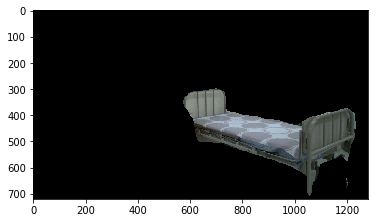

In [16]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = stream_capture_image(
        ImageType.FullView, obj_type="full_view", host=CAM_HOST,
        crob=crob)
    
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    gscene.show_pose(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected table)
    mask_out = sd.inference(color_img=cdp.color)
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))[:,:,0]
    
if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    icp_bed.clear()
    pcd = icp_bed.add_image(cdp_masked, Tc=T_bc)
    T_bs_pre = gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)
    T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
#         # front_ICP
#         T_bo_bed, fitness = icp_bed.compute_front_ICP(T_bc, To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
    # adjust
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))

    if VISUALIZE: # show final result
        icp_bed.draw(gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT))
else:
    raise(RuntimeError("bed not detected"))

#### 1.2.3  detect and add closet

In [17]:
VISUALIZE = False
if ENABLE_O3D:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="top_table", host=CAM_HOST,
                                     crob=crob)
    else:
        rdict, VIEW_MOVED_EXT = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.5)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(
        Tbs[:3, :3], 
        np.matmul(T_bc[:3,:3], (0,0,0.3))-(0,0,1))
    with gtimer.block("ICP"):
        T_bo, fitness = icp_closet.compute_front_ICP(T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
    
#     # front_cut_ICP
#     T_bo, fitness = icp_closet.compute_front_cut_ICP("closet",
#                            initial_guess, thres=0.05, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

add_backwall(gscene)

Apply point-to-point ICP
registration::RegistrationResult with fitness=6.564617e-01, inlier_rmse=1.094940e-02, and correspondence_set size of 15696
Access transformation to get result.
Transformation is:
[[-0.99926822  0.00753704  0.03749973  5.79911396]
 [ 0.03775267  0.03681683  0.99860867  0.6613502 ]
 [ 0.00614593  0.99929361 -0.03707443  0.06622292]
 [ 0.          0.          0.          1.        ]]


In [18]:
if CONNECT_MOBILE and CONNECT_CAM:
    save_pickle("gargs.pkl".format(get_now()), 
                gscene.get_gtem_args())
else:
    filelist = sorted([fname for fname in os.listdir(os.getcwd()) if fname.startswith("gargs_")])
    gtem_args = load_pickle("gargs.pkl")      
    for garg in gtem_args:
        if garg['parent'] == None and garg['link_name']=="base_link":
            if garg["name"] in gscene.NAME_DICT:
                gscene.NAME_DICT[garg["name"]].set_offset_tf(center=garg["center"], orientation_mat=Rot_rpy(garg["rpy"]))
gscene.update_markers_all() 

In [19]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

In [20]:
# # Extract triangle mesh fron rgbd image
# # If T_bc is not given, then the mesh coordinate is camera coordinate
# mesh = extract_mesh(cdp, T_bc=T_bc_new, visualize=False)

# remove_boxes = [gscene.NAME_DICT["bed_box"],
#                 gscene.NAME_DICT["closet_box"],
#                 gscene.NAME_DICT["floor_box"]
#                ]
# mesh_cut, mesh_colors = \
#     mask_boxes_mesh(mesh, remove_boxes, 
#                     VIEW_POSE_EXT, inside=False, 
#                     merge_rule=np.all, link_ref="base_link")
# gscene.create_safe(GEOTYPE.MESH, "env_mesh", link_name="base_link",
#                   dims=(1,1,1), center=(0,0,0), rpy=(0,0,0),
#                   color=(1,1,1,1), fixed=True, collision=True,
#                   vertices=mesh_cut.vertices, triangles=mesh_cut.triangles,
#                   colors=mesh_colors)


## 2. Closet cleaning

### 2.0. Prepare functions

In [21]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [22]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)

Tool Down


In [23]:
adjust_count_list = []
def look_closet_get_offset(gxter, crob, mplan, robot_name, Qref):
    for _ in range(5):
        traj, succ = get_look_motion(mplan, robot_name, Qref, 
                                     target_point=gscene.NAME_DICT["closet_leftup"],
                                     com_link=pscene.robot_chain_dict[robot_name]['link_names'][-1],
                                     view_dir=[0,0,1],timeout=1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

    adjust_count_list.append(1)
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, 
                                     obj_type="closet_{}".format(len(adjust_count_list)), 
                                     host=CAM_HOST, crob=crob)
    else:
        rdict, Qref = load_rdict("closet_{}".format(len(adjust_count_list)))
        gscene.show_pose(Qref)

    T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)

    with gtimer.block("masking"):
        pcd_masked = mask_boxes(pcd_closet, 
                            boxes=[gscene.NAME_DICT["closet_box"]], 
                            Q=Qref, inside=True, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked = mask_boxes(pcd_masked, 
                            boxes=[gscene.NAME_DICT["bed_box"], 
                                   gscene.NAME_DICT["bed_wall"], 
                                   gscene.NAME_DICT["floor_box"],
                                   gscene.NAME_DICT["back_wall"]], 
                            Q=Qref, inside=False, 
                            merge_rule=np.all, link_ref="base_link")

    with gtimer.block("adding"):
        icp_closet.add_pointcloud(pcd_masked, T_bc)

    initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
    with gtimer.block("compute_front_ICP"):
        # front_ICP
        T_bo_close, fitness = icp_closet.compute_front_ICP(
            T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)

    # calculate transform based on obtained points
    pcd_center_prev = pcd_masked.get_center()

    T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
    T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
    T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
    T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
    T_bo_c_fix[2,3] = 0

    # get Twoff from redetection
    Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
    Tbw0 = gscene.get_tf(gxter.mobile_link, Qref)
    Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
    Tbw1 = np.matmul(Tbo0, Tow1)

    Qcur = np.copy(Qref)
    Qcur[:2] = Tbw1[:2,3]
    Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)

    Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
    Tbw1tar = np.matmul(Tbo1, Tow0)
    Qtar = np.copy(Qref)
    Qtar[:2] = Tbw1tar[:2,3]
    Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)
    return Qcur, Qtar

### 2.1. Greedily execute closet cleaning

In [24]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Qcur = VIEW_MOVED_EXT
mode_switcher=ModeSwitcherKMB(pscene, push_dist=0.0)

In [25]:
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.5, timeout_loop=5.0)
gxter.get_division_dict(closet_leftup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lu, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()

Apply point-to-point ICP
registration::RegistrationResult with fitness=2.742059e-01, inlier_rmse=1.630410e-02, and correspondence_set size of 19623
Access transformation to get result.
Transformation is:
[[-9.99990128e-01  2.63027091e-03  3.58127412e-03  5.85646512e+00]
 [ 3.64579645e-03  2.49498977e-02  9.99682055e-01  7.20947125e-01]
 [ 2.54008220e-03  9.99685243e-01 -2.49592409e-02 -1.21054444e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Line idc [2, 3]
[PLAN] Try idc (2, 3)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 0: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 2: required answers acquired ===============================
======================= terminated 13: required answe

Goal reached
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 17: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
======================= terminated 11: required answers acquired ===============================
======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ======================

In [26]:
brush_face = change_tool(pscene, kmb, ToolDir.up, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter_u = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter_u.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.5, timeout_loop=5.0)
gxter_u.get_division_dict(closet_leftup, "front", "Z", None)
gxter_u.remove_covered(covereds)
gxter_u.init_base_divs(Qcur)
snode_schedule_list_lf, Qcur, covereds = gxter_u.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter_u.test_clear()

Tool UP
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.372527e-01, inlier_rmse=1.672951e-02, and correspondence_set size of 18021
Access transformation to get result.
Transformation is:
[[-9.99973044e-01  3.44103183e-03 -6.48619095e-03  5.86299725e+00]
 [-6.39058828e-03  2.71022896e-02  9.99612238e-01  7.48728522e-01]
 [ 3.61548816e-03  9.99626743e-01 -2.70795688e-02 -2.07760102e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Line idc [4]
[PLAN] Try idc (4,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 5: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 12: required answers acquired ===============================
======================= terminated 10: required a

In [27]:
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.5, timeout_loop=5.0)

gxter.get_division_dict(closet_rightup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_ru, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.395764e-01, inlier_rmse=1.605999e-02, and correspondence_set size of 12204
Access transformation to get result.
Transformation is:
[[-9.96931256e-01 -3.22654919e-03  7.82154750e-02  5.85439661e+00]
 [ 7.79570706e-02  5.00203821e-02  9.95701088e-01  6.35294951e-01]
 [-7.12504648e-03  9.98742985e-01 -4.96153500e-02 -1.05564823e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Line idc [1]
[PLAN] Try idc (1,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired f

In [28]:
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.5, timeout_loop=5.0)

gxter.get_division_dict(closet_down, "down", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(Qcur, -1, mode_switcher, look_closet_get_offset)
gxter.test_clear()

Apply point-to-point ICP
registration::RegistrationResult with fitness=2.082421e-01, inlier_rmse=1.587132e-02, and correspondence_set size of 11799
Access transformation to get result.
Transformation is:
[[-9.98555353e-01 -1.12560686e-02  5.25405455e-02  5.88020506e+00]
 [ 5.20617517e-02  3.92807997e-02  9.97871031e-01  6.91355763e-01]
 [-1.32959394e-02  9.99164811e-01 -3.86380421e-02  4.56560750e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Line idc [0, 2, 4]
[PLAN] Try idc (0, 2, 4)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 0: required answers acquired ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
Goal reached
======================= terminated 8: required 

Goal reached
======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
Goal reached
======================= terminated 2: max iteration time reached (5/5.0 s) ===============================
Goal reached
Goal reached
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
Goal reached
======================= terminated 8: max iteration time reached (5/5.0 s) ===============================
======================= terminated 9: max iteration time reached (5/5.0 s) ===============================
Goal reached
======================= terminated 5: max iteration time reached (5/5.0 s) ===============================
Goal reached
======================= terminated 3: max iteration time reached (6/5.0 s) ===============================
Goal reached
Goal reached
======================= terminated 11: max iteration time reached (6/5.0 s) ===============================
======================= t

## 3. Bed cleaning

In [29]:
brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE,)

BED_OFFSET = 0.05
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

Tool Down


In [30]:
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.5, timeout_loop=5.0)

gxter.get_division_dict(bed_mat, "front", "X", EE_HEIGHT, xout_cut=True)
gxter.init_base_divs(Qcur)

snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()

('Height Reference: ', 0.7019999811649322)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.103300e-01, inlier_rmse=1.591339e-02, and correspondence_set size of 11956
Access transformation to get result.
Transformation is:
[[-9.98865322e-01 -1.22583483e-02  4.60195876e-02  5.88792646e+00]
 [ 4.55291987e-02  3.76599193e-02  9.98252885e-01  6.98008960e-01]
 [-1.39700255e-02  9.99215424e-01 -3.70590747e-02  9.87314783e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Line idc [6]
[PLAN] Try idc (6,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 2: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 10: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
Goal reached
==============

======================= terminated 0: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 11: required answers acquired ===============================
======================= terminated 6: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
Goal reached
================

======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 9: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===========

======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= terminated 9: max iteration time reached (5/5.0 s) ===============================
======================= terminated 2: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 12: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 14: max iteration time reached (5/5.0 s) ===============================
======================= terminated 5: max iteration time reached (5/5.0 s) ===============================
======================= terminated 13: max iteration time reached (5/5.0 s) ===============================
======================= terminat

Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
======================= terminated 2: required answers acquired from other agent ===============================
[PLAN] Try idc (12,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
======================= terminated 7: max iteration time reached (5/5.0 s) ===============================
=======================

======================= terminated 19: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
Goal reached
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
[WARN] No available approach position. Try anyway
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.096044e-01, inlier_rmse=1.641225e-02, and correspondence_set size of 11344
Access transformation to get result.
Transformation is:
[[-9.99753067e-01 -2.96971930e-03  2.20224318e-02  5.81974308e+00]
 [ 2.18755354e-

Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
[PLAN] Line idc [17]
[PLAN] Try idc (17,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 3: required answers acquired ===============================
======================= terminated 15: required answers acquired from other agent ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
======================= terminated 16: required answers acquired from other agent ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 8: required answers acquired ====

binder: brush_face
rname: indy1
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.802883e-01, inlier_rmse=1.523052e-02, and correspondence_set size of 9062
Access transformation to get result.
Transformation is:
[[-9.99655801e-01 -1.88107202e-02  1.82876173e-02  5.88766686e+00]
 [ 1.87365054e-02 -2.39706353e-02  9.99537069e-01  8.88181234e-01]
 [-1.83636463e-02  9.99535675e-01  2.43148318e-02 -5.11987436e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Line idc [4, 5]
[PLAN] Try idc (4, 5)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 1: required answers acquired ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
======================

======================= terminated 6: required answers acquired ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 11: required answers acquired ===============================
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
================

Goal reached
======================= terminated 9: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 3: required answers acquired ===============================
======================= terminated 5: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 12: required answers acquired ===============================
======================= terminated 16: required answers acquired ===============================
Goal reached
==

Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 3: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 18: required answers acquired ===============================
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached

======================= terminated 18: required answers acquired from other agent ===============================
Goal reached
======================= terminated 0: required answers acquired ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 8: required answers acquired from other agent ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired ===============================
Goal reached
======================= terminated 3: required answers acquired ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 11: required answers acquired ===============================
Goal

======================= terminated 3: max iteration time reached (5/5.0 s) ===============================
======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
======================= terminated 7: max iteration time reached (5/5.0 s) ===============================
======================= terminated 6: max iteration time reached (5/5.0 s) ===============================
======================= terminated 2: max iteration time reached (5/5.0 s) ===============================
======================= terminated 0: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 9: max iteration time reached (5/5.0 s) ===============================
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= terminated 

Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
======================= terminated 1: required answers acquired from other agent ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing 

IOError: /home/rnb/Projects/rnb-planning/src/scripts/milestone_202110/save_img/closet_14.csv not found.

In [ ]:
# save_pickle("adjust_list.pkl", adjust_list)
# save_pickle("Q_all.pkl", [[snode.state.Q for snode in snode_schedule] for snode_schedule in snode_schedule_list])

## Load exp dat

In [ ]:
# adjust_list = load_pickle("adjust_list.pkl")
# gtem_args = load_pickle("gtem_args.pkl")
# Q_all = load_pickle("Q_all.pkl")

In [ ]:
# for garg in gtem_args:
#     if garg['parent'] == None and garg['link_name']=="base_link":
#         if garg["name"] in gscene.NAME_DICT:
#             gscene.NAME_DICT[garg["name"]].set_offset_tf(center=garg["center"], orientation_mat=Rot_rpy(garg["rpy"]))
# gscene.update_markers_all()        

In [ ]:
# VISUALIZE = True
# adjust_base_on(Q_all[4][0], closet_leftup)

## DEV begin

## DEV end